In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from collections import Counter
import numpy as np
from community import community_louvain
import tweepy
from tweepy.pagination import Paginator
import time

In [24]:
# ---- Step 1: Twitter API Authentication ----
bearer_token = "AAAAAAAAAAAAAAAAAAAAAAPC0gEAAAAAHlvzk%2BVXKAW%2BOwLcQK%2Fh1zx1T%2Fs%3DFy3RGsS5D2t4QvExP6CS264qHxbkLCwlHCGYC7cbW9RSxUv5Pz"
client = tweepy.Client(bearer_token=bearer_token)

# ---- Step 2: Fetch Tweets from Twitter API ----
query = "(trump OR obama OR hillary OR biden OR election OR covid OR vaccine OR coronavirus OR pandemic OR hoax) lang:en -is:retweet"
tweets = client.search_recent_tweets(
    query=query,
    tweet_fields=["author_id", "text"],
    max_results=100
)
data = []
if tweets.data:
    for tweet in tweets.data:
        data.append({"user": tweet.author_id, "text": tweet.text})
df_twitter = pd.DataFrame(data)
print(f"✅ Step 2 completed: Fetched {len(df_twitter)} tweets from Twitter API")


✅ Step 2 completed: Fetched 100 tweets from Twitter API


In [25]:
print("Sample Twitter Data:")
print(df_twitter[['user', 'text']].head(5).to_string(index=False))

Sample Twitter Data:
               user                                                                                                                                                                                text
1270022309080969219                                                @DefiantLs Jill Biden is cheering for a Crockett/AOC ticket to win.\nThat's her only hope of seeing Senile Joe lose his #1 position.
1594397548839636994                                                                                                                                                         @pulpmx Vaccine got ya down
1776771659501850624 @RapidResponse47 @POTUS Oil is down because OPEC increased their production. The U.S. oil companies were at max production before Trump was inaugurated.\n\nhttps://t.co/zKdNiGj0tX
          128146300                                                                                                                            @IAPolls2022 Since when is Michelle 

In [26]:
# ---- Step 3: Fetch Reddit Posts Using PRAW API ----
!pip install praw

import praw
import pandas as pd

reddit = praw.Reddit(
    client_id="Q_BCM3SNAW2W_DURHCcocQ",
    client_secret="GXnLy42lVVfdtLkzsJ7zcpirPyMEsw",
    user_agent="misinfo-study-script:v1.0 (by u/Personal_Athlete_396)"
)

subreddits = ["conspiracy", "truth", "politics"]  # remove banned ones

posts = []

for sub in subreddits:
    for submission in reddit.subreddit(sub).new(limit=100):
        posts.append({
            "user": str(submission.author),
            "text": submission.title + " " + submission.selftext[:500]
        })

df_reddit = pd.DataFrame(posts)
print(f"✅ Step 3 completed: Fetched {len(df_reddit)} Reddit posts from {len(subreddits)} subreddits")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Step 3 completed: Fetched 300 Reddit posts from 3 subreddits


In [27]:
# ---- Step 3: Load Kaggle Fake News Dataset ----
from google.colab import files
uploaded = files.upload()  # User uploads 'archive (2).zip'

import zipfile
import os

# Unzip in runtime
zip_path = "archive.zip"
extract_folder = "News _dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()
    print(f"Extracted Kaggle dataset from {zip_path}")
# ---- Step 3.1: Load Kaggle Fake News Dataset ----
kaggle_file_path = os.path.join(extract_folder, "Fake.csv")

try:
    df_kaggle = pd.read_csv(kaggle_file_path).head(500)
    df_kaggle = df_kaggle[['text']].rename(columns={'text': 'text'})
    df_kaggle['user'] = 'Kaggle_FakeNews'
except FileNotFoundError:
    df_kaggle = pd.DataFrame(columns=['text', 'user'])
    print(f"Fake.csv not found at {kaggle_file_path}. Skipping Kaggle data.")

# ---- Step 3.2: Load Kaggle True News Dataset ----
print("✅ Step 3.1 completed: Load Kaggle True News Dataset")
true_file_path = os.path.join(extract_folder, "True.csv")

try:
    df_true = pd.read_csv(true_file_path).head(500)
    df_true = df_true[['text']].rename(columns={'text': 'text'})
    df_true['user'] = 'Kaggle_TrueNews'
except FileNotFoundError:
    df_true = pd.DataFrame(columns=['text', 'user'])
    print(f"True.csv not found at {true_file_path}. Skipping True news data.")

Saving archive.zip to archive (2).zip
Extracted Kaggle dataset from archive.zip
✅ Step 3.1 completed: Load Kaggle True News Dataset


In [28]:
# ---- Step 4: Combine Datasets (Twitter + Kaggle + Reddit) ----

# Label each source
df_twitter["source"] = "Twitter"
df_kaggle["source"] = "Kaggle_FakeNews"
df_true["source"] = "Kaggle_TrueNews"
df_reddit["source"] = "Reddit"

# Combine all into one unified dataframe
df = pd.concat([df_twitter, df_kaggle, df_true, df_reddit], ignore_index=True)

print(f"✅ Step 4 completed: Combined total records = {len(df)}")
print("Sources included:", df['source'].value_counts().to_dict())


✅ Step 4 completed: Combined total records = 1400
Sources included: {'Kaggle_FakeNews': 500, 'Kaggle_TrueNews': 500, 'Reddit': 300, 'Twitter': 100}


In [45]:
# Print the first few rows of the combined DataFrame
print("📊 Sample Combined Data:")
print(df.head(10).to_string(index=False))  # Adjust number as needed

# Print total record count
print(f"\n✅ Total records: {len(df)}")

# Print count of records by source
print("\n📌 Records by Source:")
print(df['source'].value_counts().to_string())


📊 Sample Combined Data:
               user                                                                                                                                                                                                                                                                                                                                     text  source
1270022309080969219                                                                                                                                                                                                     @DefiantLs Jill Biden is cheering for a Crockett/AOC ticket to win.\nThat's her only hope of seeing Senile Joe lose his #1 position. Twitter
1594397548839636994                                                                                                                                                                                                                                                   

In [46]:

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=300)
X = vectorizer.fit_transform(df['text'].fillna(""))

# Compute cosine similarity matrix
similarity = (X * X.T).toarray()

# Initialize an undirected graph
G = nx.Graph()

# Add nodes to the graph with metadata
for i in range(len(df)):
    G.add_node(i,
               user=df.iloc[i]['user'],
               text=df.iloc[i]['text'][:100],  # preview for visualization
               source=df.iloc[i]['source'])

# Add edges based on similarity threshold
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if similarity[i][j] > 0.2:  # threshold can be tuned
            G.add_edge(i, j, weight=similarity[i][j])

print(f"✅ Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


✅ Graph created: 1400 nodes, 120488 edges


In [48]:
# ---- Step 6: Louvain Community Detection ----
# Run Louvain algorithm on the graph
partition = community_louvain.best_partition(G, weight='weight')

# Store community ID for each node
for node in G.nodes():
    G.nodes[node]['community'] = partition[node]

# Optional: store color list for visualization
colors = [partition[node] for node in G.nodes()]

print(f"✅ Louvain detected {len(set(partition.values()))} communities.")


✅ Louvain detected 46 communities.


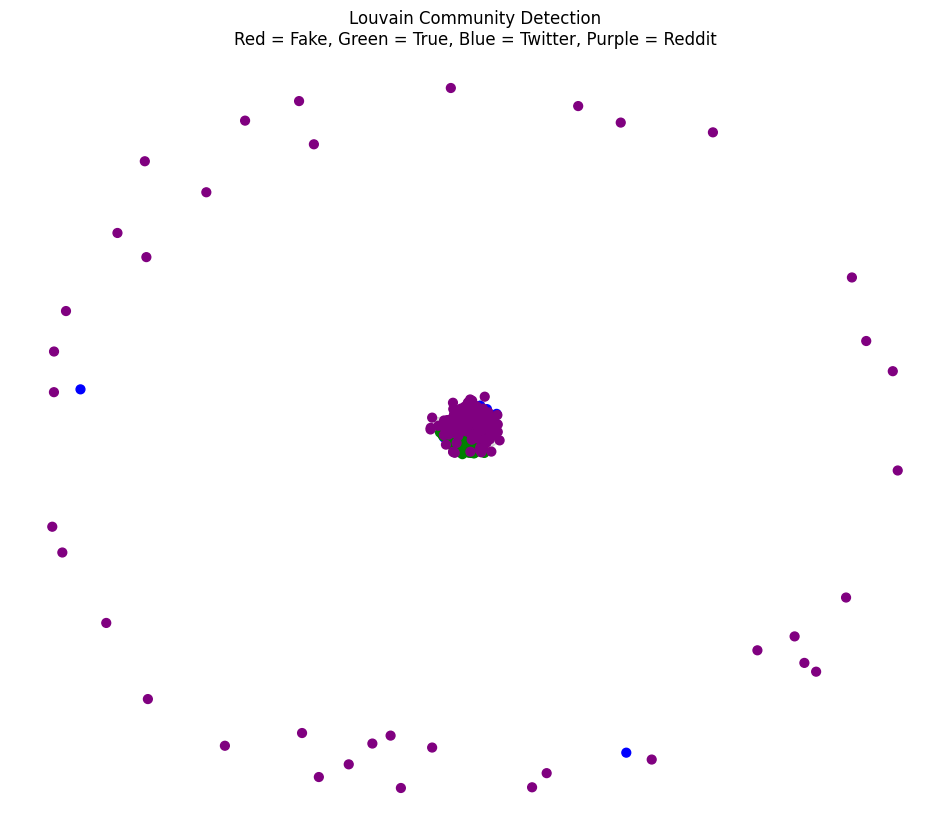

In [49]:
# ---- Step 7: Visualize Louvain Communities ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

# Color map by source
color_map = []
for node in G.nodes():
    source = G.nodes[node].get('source', 'Unknown')
    if source == 'Kaggle_FakeNews':
        color_map.append('red')
    elif source == 'Kaggle_TrueNews':
        color_map.append('green')
    elif source == 'Twitter':
        color_map.append('blue')
    elif source == 'Reddit':
        color_map.append('purple')
    else:
        color_map.append('gray')

nx.draw_networkx(
    G,
    pos,
    node_color=color_map,
    with_labels=False,
    node_size=40,
    edge_color="lightgray"
)

plt.title("Louvain Community Detection\nRed = Fake, Green = True, Blue = Twitter, Purple = Reddit")
plt.axis("off")
plt.show()


In [50]:
# ---- Step 8: PageRank Analysis ----
from collections import Counter

pagerank = nx.pagerank(G, weight='weight')
top_nodes = Counter(pagerank).most_common(5)

print("\n🚀 Top Spreaders by PageRank:")
for node, score in top_nodes:
    user = G.nodes[node].get('user', 'Unknown')
    text = G.nodes[node].get('text', '')[:200]  # limit preview length
    source = G.nodes[node].get('source', 'Unknown')
    community = G.nodes[node].get('community', 'N/A')

    print(f"🧠 Node {node} | Source: {source} | Community: {community}")
    print(f"👤 User: {user}")
    print(f"📝 Text: {text}")
    print(f"📈 PageRank: {score:.4f}\n")



🚀 Top Spreaders by PageRank:
🧠 Node 679 | Source: Kaggle_TrueNews | Community: 45
👤 User: Kaggle_TrueNews
📝 Text: WASHINGTON (Reuters) - Near the end of President Donald Trump’s rocky first year in office, White Ho
📈 PageRank: 0.0023

🧠 Node 1054 | Source: Kaggle_TrueNews | Community: 11
👤 User: Kaggle_TrueNews
📝 Text: WASHINGTON/LONDON (Reuters) - President Donald Trump on Wednesday shared anti-Muslim videos posted o
📈 PageRank: 0.0023

🧠 Node 479 | Source: Kaggle_FakeNews | Community: 11
👤 User: Kaggle_FakeNews
📝 Text: The size of Donald Trump s hands seems to be an issue, even with the so-called president. Marco Rubi
📈 PageRank: 0.0021

🧠 Node 881 | Source: Kaggle_TrueNews | Community: 10
👤 User: Kaggle_TrueNews
📝 Text: WASHINGTON (Reuters) - President Donald Trump’s eldest son, Donald Trump Jr., declined to discuss wi
📈 PageRank: 0.0020

🧠 Node 592 | Source: Kaggle_FakeNews | Community: 11
👤 User: Kaggle_FakeNews
📝 Text: Just days after Donald Trump advisor and avowed racist alt-r

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Step 9 completed: Spectral Clustering

🔷 Cluster 0 contains:
 - Node 0 (1270022309080969219): @DefiantLs Jill Biden is cheering for a Crockett/AOC ticket ...
 - Node 1 (1594397548839636994): @pulpmx Vaccine got ya down...
 - Node 3 (128146300): @IAPolls2022 Since when is Michelle Obama a politician??...

🔷 Cluster 1 contains:
 - Node 83 (1510998311200772097): @JackIsNotHereYT @quiet_follower @AnnaRMatson I get that. An...
 - Node 1129 (None): The Truth - a summary of a stump “Our impulses are being red...
 - Node 1143 (Log_Which): Financial Recessions Are Normalized By People Who Need Somet...

🔷 Cluster 2 contains:
 - Node 2 (1776771659501850624): @RapidResponse47 @POTUS Oil is down because OPEC increased t...
 - Node 17 (1675169453854670849): Green EPA slush fund:
They should subpoena Biden and ask him...
 - Node 18 (273465530): #Trump #Pushes for #Rate #Cut, Says #Powell’s ‘#Termination ...

🔷 Cluster 3 contains:
 - Node 20 (1421276138928754689): @FoxNews @BernieSanders @AOC Bulls

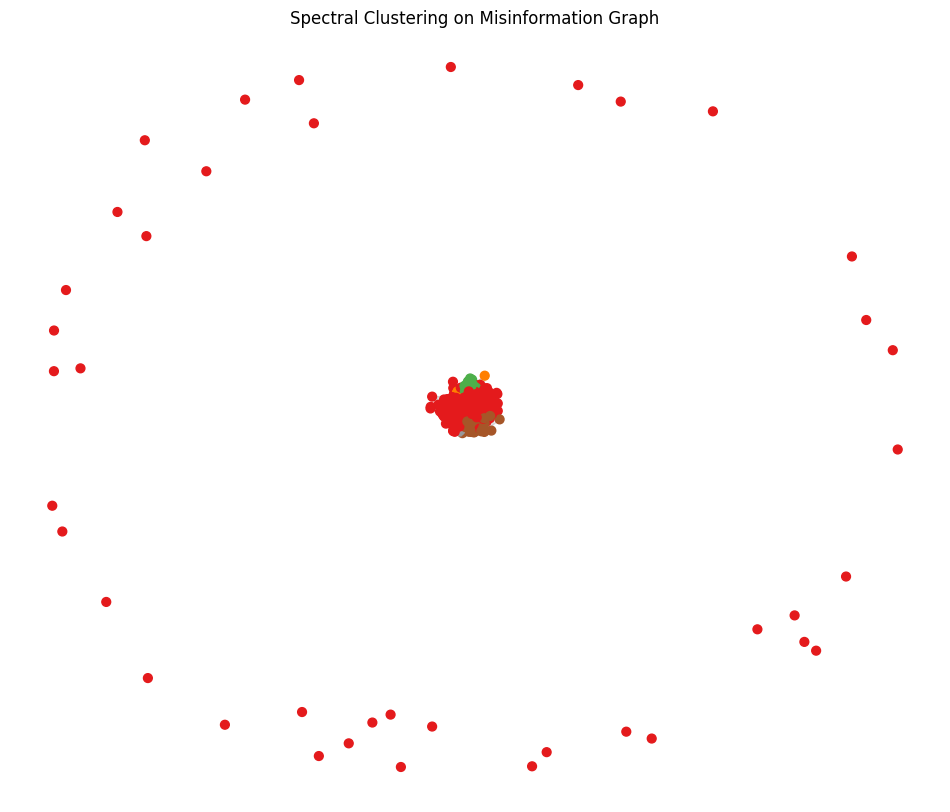

In [51]:
# ---- Step 9: Spectral Clustering ----
sim_matrix = np.where(similarity > 0.2, similarity, 0)
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt

# Filter low-similarity values
sim_matrix = np.where(similarity > 0.2, similarity, 0)

# Apply Spectral Clustering
sc = SpectralClustering(n_clusters=5, affinity='precomputed', assign_labels='kmeans', random_state=42)
labels = sc.fit_predict(sim_matrix)

# Assign cluster ID as a node attribute
for i, label in enumerate(labels):
    G.nodes[i]['spectral_cluster'] = label

# Print example nodes from each cluster
print("✅ Step 9 completed: Spectral Clustering")
for cluster_id in np.unique(labels):
    print(f"\n🔷 Cluster {cluster_id} contains:")
    for idx in np.where(labels == cluster_id)[0][:3]:  # preview first 3 nodes per cluster
        user = G.nodes[idx].get('user', 'Unknown')
        text = G.nodes[idx].get('text', '')[:60]
        print(f" - Node {idx} ({user}): {text}...")

# Visualization
plt.figure(figsize=(12, 10))
nx.draw_networkx(
    G,
    pos,
    node_color=labels,
    with_labels=False,
    node_size=40,
    edge_color="lightgray",
    cmap=plt.cm.Set1
)
plt.title("Spectral Clustering on Misinformation Graph")
plt.axis("off")
plt.show()


In [52]:
# ---- Step 10: HITS Algorithm (Hubs and Authorities) ----
# Run HITS (Hyperlink-Induced Topic Search)
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)

print("✅ Step 10 completed: HITS Algorithm")

# Display top Hubs
print("\n🏗️ Top Hubs:")
for node, score in sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:5]:
    user = G.nodes[node].get('user', 'Unknown')
    text = G.nodes[node].get('text', '')[:60]
    source = G.nodes[node].get('source', 'Unknown')
    print(f"Node {node} | {source} | User: {user} | Hub Score: {score:.4f}")
    print(f"Text: {text}...\n")

# Display top Authorities
print("\n🏛️ Top Authorities:")
for node, score in sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:5]:
    user = G.nodes[node].get('user', 'Unknown')
    text = G.nodes[node].get('text', '')[:60]
    source = G.nodes[node].get('source', 'Unknown')
    print(f"Node {node} | {source} | User: {user} | Authority Score: {score:.4f}")
    print(f"Text: {text}...\n")



✅ Step 10 completed: HITS Algorithm

🏗️ Top Hubs:
Node 679 | Kaggle_TrueNews | User: Kaggle_TrueNews | Hub Score: 0.0030
Text: WASHINGTON (Reuters) - Near the end of President Donald Trum...

Node 1054 | Kaggle_TrueNews | User: Kaggle_TrueNews | Hub Score: 0.0029
Text: WASHINGTON/LONDON (Reuters) - President Donald Trump on Wedn...

Node 479 | Kaggle_FakeNews | User: Kaggle_FakeNews | Hub Score: 0.0028
Text: The size of Donald Trump s hands seems to be an issue, even ...

Node 881 | Kaggle_TrueNews | User: Kaggle_TrueNews | Hub Score: 0.0027
Text: WASHINGTON (Reuters) - President Donald Trump’s eldest son, ...

Node 304 | Kaggle_FakeNews | User: Kaggle_FakeNews | Hub Score: 0.0027
Text: By now it s common knowledge that Donald Trump believes that...


🏛️ Top Authorities:
Node 679 | Kaggle_TrueNews | User: Kaggle_TrueNews | Authority Score: 0.0030
Text: WASHINGTON (Reuters) - Near the end of President Donald Trum...

Node 1054 | Kaggle_TrueNews | User: Kaggle_TrueNews | Authority Score:

In [53]:
# ---- Step 11: Random Walk with Restart (RWR) ----
def random_walk_with_restart(G, start_node, alpha=0.85, max_iter=100, tol=1e-6):
    nodes = list(G.nodes())
    idx_map = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    r = np.zeros(n)
    r[idx_map[start_node]] = 1
    p = r.copy()

    A = nx.to_numpy_array(G, nodelist=nodes)
    A = A / A.sum(axis=0, keepdims=True)
    A = np.nan_to_num(A)

    for _ in range(max_iter):
        r_new = alpha * A @ r + (1 - alpha) * p
        if np.linalg.norm(r_new - r, 1) < tol:
            break
        r = r_new

    return {nodes[i]: score for i, score in enumerate(r)}

# Choose a starting node (e.g. one with highest degree or random)
start_node = max(G.degree, key=lambda x: x[1])[0]  # high-degree node

rwr_scores = random_walk_with_restart(G, start_node)
top_rwr = sorted(rwr_scores.items(), key=lambda x: x[1], reverse=True)[:5]

print("✅ Step 11 completed: Random Walk with Restart")
print(f"🔁 Starting from Node {start_node} | User: {G.nodes[start_node].get('user')} | Source: {G.nodes[start_node].get('source')}")

for node, score in top_rwr:
    user = G.nodes[node].get('user', 'Unknown')
    text = G.nodes[node].get('text', '')[:60]
    source = G.nodes[node].get('source', 'Unknown')
    print(f"Node {node} | {source} | User: {user} | Score: {score:.4f}")
    print(f"Text: {text}...\n")



<ipython-input-53-6d349d4f948f>:12: RuntimeWarning: invalid value encountered in divide
  A = A / A.sum(axis=0, keepdims=True)


✅ Step 11 completed: Random Walk with Restart
🔁 Starting from Node 1054 | User: Kaggle_TrueNews | Source: Kaggle_TrueNews
Node 1054 | Kaggle_TrueNews | User: Kaggle_TrueNews | Score: 0.1522
Text: WASHINGTON/LONDON (Reuters) - President Donald Trump on Wedn...

Node 1047 | Kaggle_TrueNews | User: Kaggle_TrueNews | Score: 0.0024
Text: LONDON (Reuters) - U.S. President Donald Trump sparked outra...

Node 679 | Kaggle_TrueNews | User: Kaggle_TrueNews | Score: 0.0024
Text: WASHINGTON (Reuters) - Near the end of President Donald Trum...

Node 479 | Kaggle_FakeNews | User: Kaggle_FakeNews | Score: 0.0022
Text: The size of Donald Trump s hands seems to be an issue, even ...

Node 881 | Kaggle_TrueNews | User: Kaggle_TrueNews | Score: 0.0022
Text: WASHINGTON (Reuters) - President Donald Trump’s eldest son, ...



In [55]:
# ---- Step 12: Evaluation Metrics ----
print("✅ Step 12: Evaluation Metrics")
print("📊 Graph Statistics")
print(f"• Number of Nodes: {G.number_of_nodes()}")
print(f"• Number of Edges: {G.number_of_edges()}")
print(f"• Graph Density: {nx.density(G):.4f}")

# Louvain modularity (requires partition to be defined)
try:
    modularity = community_louvain.modularity(partition, G)
    print(f"• Louvain Modularity Score: {modularity:.4f}")
except Exception as e:
    print(f"⚠️ Modularity computation failed: {e}")

# Connected components
num_components = nx.number_connected_components(G)
print(f"• Number of Connected Components: {num_components}")


✅ Step 12: Evaluation Metrics
📊 Graph Statistics
• Number of Nodes: 1400
• Number of Edges: 120488
• Graph Density: 0.1230
• Louvain Modularity Score: 0.3939
• Number of Connected Components: 41


In [57]:
# ---- Step 14: Classification Evaluation (Fake vs True) ----
from sklearn.metrics import precision_score, recall_score, f1_score

print("✅ Step 14: Classification Evaluation (Fake vs True)")

true_labels = []
pred_labels = []

# Assign binary ground truth and simulate prediction from community ID
for node in G.nodes():
    source = G.nodes[node].get('source', '')
    if source in ['Kaggle_FakeNews', 'Kaggle_TrueNews']:
        true_label = 1 if source == 'Kaggle_FakeNews' else 0
        true_labels.append(true_label)

        # Predict based on community assignment: even vs odd (simplified logic)
        pred_label = partition.get(node, 0) % 2
        pred_labels.append(pred_label)

# Evaluate if we have enough ground truth
if true_labels:
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)

    print(f"📌 Precision: {precision:.4f}")
    print(f"📌 Recall:    {recall:.4f}")
    print(f"📌 F1 Score:  {f1:.4f}")
    print(f"🧮 Evaluated on {len(true_labels)} labeled nodes")
else:
    print("⚠️ No labeled Kaggle Fake/True news nodes found for evaluation.")



✅ Step 14: Classification Evaluation (Fake vs True)
📌 Precision: 0.5360
📌 Recall:    0.7740
📌 F1 Score:  0.6334
🧮 Evaluated on 1000 labeled nodes


In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

print("✅ Step 15: Logistic Regression (Structural Features Only)")

X_features = []
y_labels = []
node_ids = []

for node in G.nodes():
    source = G.nodes[node].get('source', '')
    if source in ['Kaggle_FakeNews', 'Kaggle_TrueNews']:
        node_ids.append(node)
        community = partition.get(node, 0)
        degree = G.degree[node]
        pr = pagerank.get(node, 0)
        X_features.append([community, degree, pr])
        y_labels.append(1 if source == 'Kaggle_FakeNews' else 0)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n📊 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=['True News', 'Fake News']))

logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_precision = precision_score(y_test, y_pred)
logreg_recall = recall_score(y_test, y_pred)
logreg_f1 = f1_score(y_test, y_pred)


✅ Step 15: Logistic Regression (Structural Features Only)

📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

   True News       0.90      0.49      0.63       150
   Fake News       0.65      0.95      0.77       150

    accuracy                           0.72       300
   macro avg       0.77      0.72      0.70       300
weighted avg       0.77      0.72      0.70       300



In [79]:
# ---- Step 16: Hidden Community Exploration ----
from collections import defaultdict

# Group nodes by their Louvain community
community_nodes = defaultdict(list)
for node, comm_id in partition.items():
    community_nodes[comm_id].append(node)

print("✅ Step 16: Hidden Community Breakdown")

# Print top 3 sample nodes from each community
for comm_id, nodes in community_nodes.items():
    print(f"\n🔍 Community {comm_id} — Total nodes: {len(nodes)}")
    for n in nodes[:3]:
        user = G.nodes[n].get('user', 'Unknown')
        source = G.nodes[n].get('source', 'Unknown')
        text = G.nodes[n].get('text', '')[:60]
        print(f" - Node {n} | Source: {source} | User: {user}")
        print(f"   Text: {text}...")


✅ Step 16: Hidden Community Breakdown

🔍 Community 2 — Total nodes: 134
 - Node 0 | Source: Twitter | User: 1270022309080969219
   Text: @DefiantLs Jill Biden is cheering for a Crockett/AOC ticket ...
 - Node 2 | Source: Twitter | User: 1776771659501850624
   Text: @RapidResponse47 @POTUS Oil is down because OPEC increased t...
 - Node 12 | Source: Twitter | User: 823293618781724672
   Text: @MadMadMadWorld_ @ArtCandee @AngryDemVet Also socialism isn’...

🔍 Community 13 — Total nodes: 152
 - Node 1 | Source: Twitter | User: 1594397548839636994
   Text: @pulpmx Vaccine got ya down...
 - Node 38 | Source: Twitter | User: 1849535731384893440
   Text: @bearsarestupid @uhohspag00 @ImMeme0 On the Washington Monum...
 - Node 48 | Source: Twitter | User: 1688921149240180737
   Text: @FightWithMemes THEY ALL GOT PAID. COVID WAS TO KILL AMERICA...

🔍 Community 11 — Total nodes: 519
 - Node 3 | Source: Twitter | User: 128146300
   Text: @IAPolls2022 Since when is Michelle Obama a politician??...


In [40]:
pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00


In [80]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import numpy as n

✅ Step 18: Tuned GNN with Structural Features
Epoch 0, Loss: 20.2670
Epoch 25, Loss: 2.3777
Epoch 50, Loss: 1.0333
Epoch 75, Loss: 1.0177
Epoch 100, Loss: 0.7779
Epoch 125, Loss: 1.1483
Epoch 150, Loss: 0.5257
Epoch 175, Loss: 0.5411
Epoch 200, Loss: 0.7204
Epoch 225, Loss: 0.4769
Epoch 250, Loss: 0.6037
Epoch 275, Loss: 0.6584

📊 Tuned GNN Test Accuracy: 0.7833
📋 Tuned GNN Classification Report:
              precision    recall  f1-score   support

   True News       0.72      0.92      0.81       150
   Fake News       0.89      0.65      0.75       150

    accuracy                           0.78       300
   macro avg       0.81      0.78      0.78       300
weighted avg       0.81      0.78      0.78       300



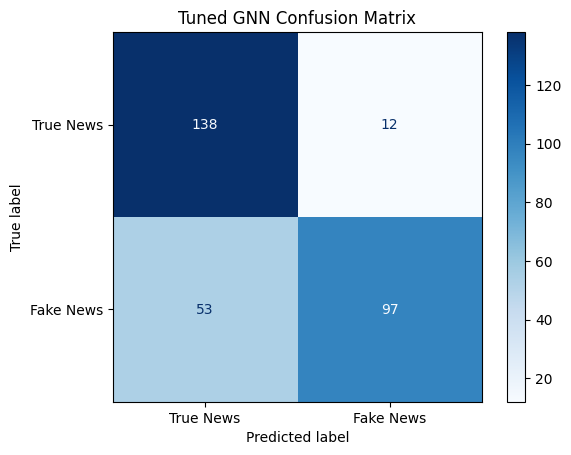

In [91]:
print("✅ Step 18: Tuned GNN with Structural Features")

import torch
import torch.nn.functional as F
from torch.nn import LeakyReLU
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv

# Use already prepared features: X_struct and labels y

# Assign to graph
for i, node in enumerate(G.nodes()):
    G.nodes[node]['x'] = X_struct[i]
    G.nodes[node]['y'] = y[i]

data = from_networkx(G)
data.x = torch.tensor(X_struct, dtype=torch.float)
data.y = torch.tensor(y, dtype=torch.long)

mask = data.y != -1
train_mask_idx, test_mask_idx = train_test_split(torch.where(mask)[0], test_size=0.3, random_state=42)

# 🔧 Tuned GCN model
class TunedGCN(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 2)
        self.leaky_relu = LeakyReLU(0.1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train
model = TunedGCN(input_dim=data.x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[train_mask_idx], data.y[train_mask_idx])
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
true_y = data.y[test_mask_idx]
pred_y = pred[test_mask_idx]

acc = int((pred_y == true_y).sum()) / len(true_y)
precision = precision_score(true_y, pred_y, zero_division=0)
recall = recall_score(true_y, pred_y, zero_division=0)
f1 = f1_score(true_y, pred_y, zero_division=0)

print(f"\n📊 Tuned GNN Test Accuracy: {acc:.4f}")
print("📋 Tuned GNN Classification Report:")
print(classification_report(true_y, pred_y, target_names=['True News', 'Fake News']))

# Confusion Matrix
cm = confusion_matrix(true_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True News', 'Fake News'])
disp.plot(cmap='Blues')
plt.title("Tuned GNN Confusion Matrix")
plt.show()


In [93]:
# Final evaluation (if not already done above)
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

# Use test_mask_idx if available
if 'test_mask_idx' in locals():
    correct = pred[test_mask_idx] == data.y[test_mask_idx]
    acc = int(correct.sum()) / len(test_mask_idx)
    print(f"✅ Final GNN Test Accuracy: {acc:.4f}")
else:
    print("⚠️ test_mask_idx not defined — skipping final evaluation.")


✅ Final GNN Test Accuracy: 0.7833


In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("✅ Step 20: Final Model Comparison\n")
print("📊 Final Evaluation Summary of All Techniques")
print(f"{'Technique':<30}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1 Score':<12}")
print("-" * 75)

# --- Louvain ---
louvain_precision = precision_score(true_labels, pred_labels, zero_division=0)
louvain_recall = recall_score(true_labels, pred_labels, zero_division=0)
louvain_f1 = f1_score(true_labels, pred_labels, zero_division=0)
louvain_accuracy = accuracy_score(true_labels, pred_labels)

# --- Logistic Regression ---
logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_precision = precision_score(y_test, y_pred, zero_division=0)
logreg_recall = recall_score(y_test, y_pred, zero_division=0)
logreg_f1 = f1_score(y_test, y_pred, zero_division=0)

# --- GNN ---
gnn_accuracy = acc  # from earlier step
gnn_precision = precision
gnn_recall = recall
gnn_f1 = f1

# Print all results
print(f"{'Louvain (Guess)':<30}{louvain_accuracy:<12.2f}{louvain_precision:<12.2f}{louvain_recall:<12.2f}{louvain_f1:<12.2f}")
print(f"{'Logistic Regression':<30}{logreg_accuracy:<12.2f}{logreg_precision:<12.2f}{logreg_recall:<12.2f}{logreg_f1:<12.2f}")
print(f"{'Graph Neural Network (GNN)':<30}{gnn_accuracy:<12.2f}{gnn_precision:<12.2f}{gnn_recall:<12.2f}{gnn_f1:<12.2f}")


✅ Step 20: Final Model Comparison

📊 Final Evaluation Summary of All Techniques
Technique                     Accuracy    Precision   Recall      F1 Score    
---------------------------------------------------------------------------
Louvain (Guess)               0.55        0.54        0.77        0.63        
Logistic Regression           0.72        0.65        0.95        0.77        
Graph Neural Network (GNN)    0.78        0.89        0.65        0.75        
